In [2]:
import re
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline
sns.set()
sns.set_style({'ytick.bottom': True})
sns.axes_style('white')
from sklearn.model_selection import cross_val_score


In [8]:
def TrainValTest(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train_val, X_test, y_train_val, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=3)
    return X_train, X_val, X_test, y_train, y_val, y_test
    # fit linear regression to training data
        

In [4]:
with open('data/project_2_datard2.pkl', 'rb') as picklefile:
    data = pickle.load(picklefile)

In [5]:
df = pd.DataFrame(data)

In [6]:
df.drop_duplicates(subset = 'id',inplace=True)
df.dropna(inplace=True)

In [7]:
missed_genre_ids = df[df.genre.apply(lambda x: bool(re.search(r'\d', x)))].id
df2 = df.set_index('id').drop(labels=missed_genre_ids).reset_index()

In [8]:
df2.release_date = df2.release_date.apply(lambda x: int(x))

In [9]:
df2.last_sold = df2.last_sold.apply(lambda x: dt.datetime.strptime(x, '%d %b %y'))
df2.last_sold = df2.last_sold.apply(lambda x: x.toordinal())


In [195]:
df2.release_date.mean()

1995.7640589714874

In [62]:
df2['genre'] = df2.genre.apply(lambda x: ''.join(x.split(',')[:2]))
genrecounts = df2.genre.value_counts()
othergenres = list(genrecounts[genrecounts<=60].index)
df2['genre'] = df2['genre'].replace(othergenres, 'Other')

countrycounts = df2.country.value_counts()
othercountries = list(countrycounts[countrycounts<50].index)
df2.country = df.country.replace(othercountries, 'Other')

formatcounts = df2['format'].value_counts()
otherformats = list(formatcounts[formatcounts<50].index)
df2['format'] = df2['format'].replace(otherformats, 'Other')
df2['format'].value_counts()
#df2['style'] = df2['style'].apply(lambda x: ''.join(x.split(',')[:2]))


Vinyl       31797
CD          14508
Cassette      593
CDr           529
Other         135
DVD           115
Name: format, dtype: int64

discard outliers

In [ ]:
df2=df2[df2['median']]

In [63]:
df_mvp = df2[['ask_price','highest', 'lowest', 'comment_num','country','format','genre',\
              'have_num','last_sold','link_num', 'num_for_sale',\
              'num_ratings','rating','release_date','want_num']]
df_mvp_target = df2['median']

In [64]:
#df_mvp.dtypes
df_mvp_dummies = pd.get_dummies(df_mvp);

In [65]:
X_train, X_val, X_test, y_train, y_val, y_test = \
TrainValTest(df_mvp_dummies, df_mvp_target)

In [66]:
lm = LinearRegression()
lm.fit(X_train, y_train)
alphavec = 10**np.linspace(0,200,500)
alpha = -1
lm_reg = Ridge(alpha=alpha)
lm_lasso = Lasso(alpha=alpha)
#lm_regCV = RidgeCV(alphas=alphavec, cv=5)
#lm_lassoCV = LassoCV(alphas=alphavec, cv=5,tol=0.1)
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.5f}')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

#lm_lassoCV.fit(X_train, y_train)
#lm_regCV.fit(X_train, y_train)
lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.5f}')

lm_lasso.fit(X_train_scaled, y_train)
print(f'Lasso Regression val R^2: {lm_lasso.score(X_val_scaled, y_val):.5f}')
#print(f'lasso Regression val R^2: {lm_lassoCV.score(X_val_scaled, y_val):.5f}')
#lm_poly.fit(X_train_poly, y_train)
#print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
#print(lm.score(X_train, y_train))
print('mean: ',np.mean(cross_val_score(lm_reg, df_mvp_dummies, df_mvp_target, cv=5, scoring = 'r2')))
list(zip(df_mvp_dummies.columns, lm.coef_))


Linear Regression val R^2: 0.92929
Ridge Regression val R^2: 0.92929
Lasso Regression val R^2: 0.52929
mean:  0.9235167481491693


[('ask_price', 0.04572100568181788),
 ('highest', 0.2457068008395203),
 ('lowest', 0.8306683495103044),
 ('comment_num', 0.12116843504094055),
 ('have_num', -0.0017206710772499911),
 ('last_sold', 0.0002423837418966679),
 ('link_num', -0.02610725524431806),
 ('num_for_sale', -0.0004446664806252165),
 ('num_ratings', -6.947669919774024e-05),
 ('rating', 0.21852011461661136),
 ('release_date', 0.0020894670429444026),
 ('want_num', 0.0055226660089622015),
 ('country_Australia', -0.06055898859593536),
 ('country_Australia & New Zealand', -1.155472484167591),
 ('country_Austria', 0.5373145710694225),
 ('country_Belgium', 0.00506775531758521),
 ('country_Benelux', 0.483135407234201),
 ('country_Brazil', -0.002117581431098416),
 ('country_Canada', -0.16285427001153585),
 ('country_Denmark', 0.023252210026293768),
 ('country_Europe', 0.11795587004942211),
 ('country_Finland', -0.09071708004123093),
 ('country_France', 0.03920030049816254),
 ('country_German Democratic Republic (GDR)', 0.204748

### drop price info
our model figured out that a linear combo of lowest and highest price with a small adjustment for rating was a good predictor for median--duh. Let's remove those and try with less information. 

In [68]:
df3 = df_mvp.drop(labels = ['ask_price','highest','lowest'], axis=1)
df3_dum = pd.get_dummies(df3)
X2_train, X2_val, X2_test, y2_train, y2_val, y2_test = \
TrainValTest(df3_dum, df_mvp_target)

Index(['comment_num', 'have_num', 'last_sold', 'link_num', 'num_for_sale',
       'num_ratings', 'rating', 'release_date', 'want_num',
       'country_Australia', 'country_Australia & New Zealand',
       'country_Austria', 'country_Belgium', 'country_Benelux',
       'country_Brazil', 'country_Canada', 'country_Denmark', 'country_Europe',
       'country_Finland', 'country_France',
       'country_German Democratic Republic (GDR)', 'country_Germany',
       'country_Germany, Austria, & Switzerland', 'country_Greece',
       'country_Hungary', 'country_Israel', 'country_Italy', 'country_Jamaica',
       'country_Japan', 'country_Netherlands', 'country_New Zealand',
       'country_Norway', 'country_Other', 'country_Poland', 'country_Portugal',
       'country_Russia', 'country_Scandinavia', 'country_Spain',
       'country_Sweden', 'country_Switzerland', 'country_UK',
       'country_UK & Europe', 'country_US', 'country_USA & Canada',
       'country_Yugoslavia', 'country_unknown', 'fo

In [197]:
df3.columns

Index(['comment_num', 'country', 'format', 'genre', 'have_num', 'last_sold',
       'link_num', 'num_for_sale', 'num_ratings', 'rating', 'release_date',
       'want_num'],
      dtype='object')

In [76]:
lm2 = LinearRegression()
lm.fit(X2_train, y2_train)
alphavec = 10**np.linspace(0,200,500)
alpha = 5
lm_reg2 = Ridge(alpha=alpha)
lm_lasso2 = Lasso(alpha=alpha)
#lm_regCV = RidgeCV(alphas=alphavec, cv=5)
#lm_lassoCV = LassoCV(alphas=alphavec, cv=5,tol=0.1)
lm2.fit(X2_train, y2_train)
print(f'Linear Regression train R^2: {lm.score(X2_train, y2_train):.5f}')
print(f'Linear Regression val R^2: {lm.score(X2_val, y2_val):.5f}')

scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train.values)
X2_val_scaled = scaler.transform(X2_val.values)
X2_test_scaled = scaler.transform(X2_test.values)

lm_reg2.fit(X2_train_scaled, y2_train)
print(f'Ridge Regression train R^2: {lm_reg2.score(X2_train_scaled, y2_train):.5f}')
print(f'Ridge Regression val R^2: {lm_reg2.score(X2_val_scaled, y2_val):.5f}')

lm_lasso2.fit(X2_train_scaled, y2_train)
print(f'Lasso Regression train R^2: {lm_lasso2.score(X2_train_scaled, y2_train):.5f}')
print(f'Lasso Regression val R^2: {lm_lasso2.score(X2_val_scaled, y2_val):.5f}')
#print(f'lasso Regression val R^2: {lm_lassoCV.score(X_val_scaled, y_val):.5f}')
#lm_poly.fit(X_train_poly, y_train)
#print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
#print(lm.score(X_train, y_train))
#print('mean: ',np.mean(cross_val_score(lm_reg, df3_dum.drop('median'), df3_dum['median'], cv=5, scoring = 'r2')))
list(zip(df3_dum.columns, lm2.coef_))

Linear Regression train R^2: 0.30281
Linear Regression val R^2: 0.24071
Ridge Regression train R^2: 0.30281
Ridge Regression val R^2: 0.24071
Lasso Regression train R^2: 0.09513
Lasso Regression val R^2: 0.07372


[('comment_num', 1.2925270877404624),
 ('have_num', -0.0038742842577822664),
 ('last_sold', -0.001033324869945132),
 ('link_num', 0.18019014495471913),
 ('num_for_sale', -0.07906292409532853),
 ('num_ratings', -0.0729085552716324),
 ('rating', 2.947412007327154),
 ('release_date', -0.08771807189303038),
 ('want_num', 0.060524579535676803),
 ('country_Australia', 0.8347679204832206),
 ('country_Australia & New Zealand', -2.863221034398545),
 ('country_Austria', 0.48297033042312554),
 ('country_Belgium', 0.47150955715362286),
 ('country_Benelux', 3.1038241896890586),
 ('country_Brazil', -1.5901922259950263),
 ('country_Canada', -0.5660103934983648),
 ('country_Denmark', -0.45075712082146135),
 ('country_Europe', 0.32730207029045105),
 ('country_Finland', -0.6471055303876884),
 ('country_France', 0.047780942468574415),
 ('country_German Democratic Republic (GDR)', -2.2090823936676314),
 ('country_Germany', 0.38472297790131255),
 ('country_Germany, Austria, & Switzerland', -1.7471874163066

training R<sup>2</sup> of 0.3, validation of 0.24--let's try adding some interaction features

In [128]:
poly = PolynomialFeatures()

X2_train_poly = poly.fit_transform(X2_train)
X2_val_poly = poly.transform(X2_val)
X2_test_poly = poly.transform(X2_test)

scaler = StandardScaler()
X2_train_poly_scaled = scaler.fit_transform(X2_train_poly)
X2_val_poly_scaled = scaler.transform(X2_val_poly)
X2_test_poly_scaled = scaler.transform(X2_test_poly)

lm2_poly = LinearRegression()
lm2_poly.fit(X2_train_poly_scaled, y2_train)
print(f'Poly Regression train R^2: {lm2_poly.score(X2_train_poly_scaled, y2_train):.5f}')
print(f'Poly Regression val R^2: {lm2_poly.score(X2_val_poly_scaled, y2_val):.5f}')
list(zip(poly.get_feature_names(X2_train.columns), lm2_poly.coef_))

Poly Regression train R^2: 0.48182
Poly Regression val R^2: -1035843321251977232384.00000


[('1', -427908518.5492087),
 ('comment_num', 27451831689.183475),
 ('have_num', 2539122491543.3647),
 ('last_sold', -66361195.15305232),
 ('link_num', -1860438937371.4944),
 ('num_for_sale', 968816653011.8429),
 ('num_ratings', 441170271033.7261),
 ('rating', -239390996563.11557),
 ('release_date', -2725807345.7181115),
 ('want_num', 1223243888940.2585),
 ('country_Australia', -367820290005.14124),
 ('country_Australia & New Zealand', 151824257075.72925),
 ('country_Austria', 2240273036129.49),
 ('country_Belgium', -349150849261.8447),
 ('country_Benelux', 1459278927542.7908),
 ('country_Brazil', -748316660810.047),
 ('country_Canada', -322671032486.55383),
 ('country_Denmark', -343759737521.64386),
 ('country_Europe', -265715074340.6328),
 ('country_Finland', 272427978722.37225),
 ('country_France', -157709553178.3403),
 ('country_German Democratic Republic (GDR)', 1088110894071.5616),
 ('country_Germany', -397619818485.29724),
 ('country_Germany, Austria, & Switzerland', -87996783946

massive overfitting--let's regulate.

In [169]:
alphas = np.linspace(-0.2,1, 20)
error_vec_train = np.zeros(10)
error_vec_val = np.zeros(10)
for i, alpha in enumerate(alphas):
    print(i)
    lm2_lasso= Lasso(alpha=alpha)
    lm2_lasso.fit(X2_train_poly_scaled, y2_train)

# print(lm2_lasso.score(X2_train_poly_scaled, y2_train))
# print(lm2_lasso.score(X2_val_poly_scaled, y2_val))
# sorted(list(zip(abs(lm2_lasso.coef_), poly.get_feature_names(X2_train.columns))),reverse=True)

0
1
2
3


KeyboardInterrupt: 

In [191]:
lasso_model = LassoCV(cv=5)
lasso_model.fit(X2_train_poly_scaled, y2_train)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1069.1212927680463, tolerance: 584.4586833301892
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4199.812856096309, tolerance: 584.4586833301892
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7775.921353278216, tolerance: 584.4586833301892
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did n

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3022.3786282804795, tolerance: 601.1601563500898
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8042.048043559771, tolerance: 601.1601563500898
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9126.468254052103, tolerance: 601.1601563500898
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did n

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [199]:
cross_val_score(lasso_model, X2_train_poly_scaled, y2_train, scoring='r2')

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2122.727404692676, tolerance: 409.79747985881124
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4144.106687012594, tolerance: 409.79747985881124
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want t

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1403.1782552208751, tolerance: 373.58827288315524
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3486.1405136391986, tolerance: 373.58827288315524
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4978.132428957149, tolerance: 373.58827288315524
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2159.439694364555, tolerance: 380.6006515479982
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4742.847789214458, tolerance: 380.6006515479982
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6302.492441436043, tolerance: 380.6006515479982
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did no

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872.3210735064931, tolerance: 441.06374763959724
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 632.7178958286531, tolerance: 441.06374763959724
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 771.4165749894455, tolerance: 441.06374763959724
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3084.4252163118217, tolerance: 403.46550925620863
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2775.640078853816, tolerance: 403.46550925620863
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2996.7202563001774, tolerance: 403.46550925620863
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective d

array([0.31495698, 0.3422857 , 0.35321363])

[(8.830818845675877, 'rating want_num'),
 (2.5037632801233007, 'num_for_sale want_num'),
 (2.2459467967419884, 'num_for_sale rating'),
 (2.2336666045458986, 'num_ratings want_num'),
 (2.218237620360506, 'have_num rating'),
 (2.008982391108333, 'want_num genre_Rock'),
 (1.6253708608721316, 'have_num num_for_sale'),
 (1.2054614616316939, 'want_num genre_Electronic Hip Hop'),
 (1.1965060986073817, 'rating^2'),
 (0.944595690792411, 'want_num genre_Non-Music'),
 (0.8339708615381092, 'comment_num country_Scandinavia'),
 (0.8311420259638176, 'want_num genre_Electronic Rock'),
 (0.7694953922038612, 'want_num genre_Other'),
 (0.5934003431821403, 'release_date genre_Electronic'),
 (0.5729121233623296, 'num_for_sale^2'),
 (0.5537251490508921, 'last_sold release_date'),
 (0.49995096878606404, 'comment_num genre_Rock'),
 (0.4465248109577156, 'want_num genre_Jazz'),
 (0.3851853834468481, 'want_num country_UK & Europe'),
 (0.3508896825592208, 'comment_num rating'),
 (0.3281144331388612, 'have_num gen

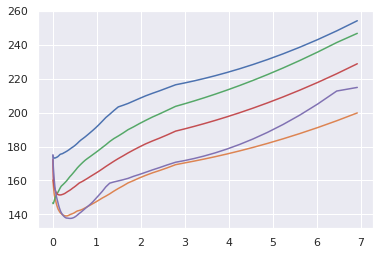

In [194]:
plt.plot(lasso_model.alphas_,lasso_model.mse_path_)
sorted(list(zip(abs(lasso_model.coef_), poly.get_feature_names(X2_train.columns))),reverse=True)
#print(lasso_model.alpha_)#lasso_model.score(X2_val_poly_scaled, y_val)

In [126]:
sorted(list(zip(abs(lm2_poly_lassoCV.coef_), poly.get_feature_names(X2_train.columns))))

[(5.005005005004932, 'num_ratings country_Jamaica'),
 (5.005005005004932, 'num_ratings country_Japan'),
 (15.015015015014797, 'num_ratings country_Italy'),
 (15.015015015014797, 'num_ratings country_Netherlands'),
 (25.02502502502466, 'num_ratings country_Israel'),
 (25.02502502502466, 'num_ratings country_New Zealand'),
 (35.035035035035435, 'num_ratings country_Hungary'),
 (35.035035035035435, 'num_ratings country_Norway'),
 (45.0450450450453, 'num_ratings country_Greece'),
 (45.0450450450453, 'num_ratings country_Other'),
 (55.05505505505516, 'num_ratings country_Germany, Austria, & Switzerland'),
 (55.05505505505516, 'num_ratings country_Poland'),
 (65.06506506506503, 'num_ratings country_Germany'),
 (65.06506506506503, 'num_ratings country_Portugal'),
 (75.07507507507489, 'num_ratings country_German Democratic Republic (GDR)'),
 (75.07507507507489, 'num_ratings country_Russia'),
 (85.08508508508476, 'num_ratings country_France'),
 (85.08508508508476, 'num_ratings country_Scandinav

In [127]:
alphavec = np.linspace(-10,10,1000)
lm2_poly_lassoCV2 = LassoCV(alphas=alphavec, cv=5, max_iter=10000)
#lm2_poly_reg.fit(X2_train_poly, y_train)
lm2_poly_lassoCV2.fit(X2_train_poly_scaled, y_train)

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 691.7007138808258, tolerance: 618.2949243318786
  tol, rng, random, positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2171.352904564701, tolerance: 589.8135116500304
  tol, rng, random, positive)


KeyboardInterrupt: 

In [57]:
df2['have_want_ratio'] = df2['have_num']/df2['want_num'] 
df2['rating_scaled'] = df2['rating']* df2['num_ratings']

In [77]:
df2['have_want_ratio'] = df2['have_want_ratio'].replace(np.inf, 0)
df2['log_hvratio'] = df2['have_want_ratio'].apply(lambda x: 0 if x==0 else np.log(x))
df2['log_nfs'] = df2['num_for_sale'].apply(lambda x: 0 if x==0 else np.log(x))

In [110]:
numerical_cols=[]
for idx, dtype in enumerate(df3.dtypes):
    if dtype !='object' and df3.columns[idx]!='id':
        numerical_cols.append(df3.columns[idx])
numerical_cols

['comment_num',
 'have_num',
 'last_sold',
 'link_num',
 'median',
 'num_for_sale',
 'num_ratings',
 'rating',
 'release_date',
 'want_num',
 'have_want_ratio',
 'rating_scaled',
 'log_hvratio']

In [83]:
X, y = df_mvp_dummies, df_mvp_target # rename for ease of use
# split off test data
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
#from train set, split off validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [120]:
X3_train, X3_val, X3_test, y3_train, y3_val, y3_test = TrainValTest(df3[numerical_cols].drop('median', axis=1),df3['median'])
lm3 = LinearRegression()
lm3.fit(X3_train, y3_train)
lm3.score(X3_val, y3_val)

(32679, 12) (32679,)
(10894, 12) (10894,)
(10894, 12) (10894,)


0.26295859185175396

In [123]:
#alphavec = 10**np.linspace(0,200,500)
lm_reg = Ridge(alpha=-100)
#lm_lassoCV = LassoCV(alphas=alphavec, cv=5)
#lm_regCV = RidgeCV(alphas=alphavec, cv=5)
#lm_lassoCV = LassoCV(alphas=alphavec, cv=5,tol=0.1)
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.5f}')

#lm_lassoCV.fit(X_train, y_train)
#lm_regCV.fit(X_train, y_train)
lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.5f}')

#lm_lasso.fit(X_train_scaled, y_train)
#print(f'lasso Regression val R^2: {lm_lassoCV.score(X_val_scaled, y_val):.5f}')
#lm_poly.fit(X_train_poly, y_train)
#print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.32601
Ridge Regression val R^2: 0.28945


In [26]:
list(zip(X_train.columns, lm.coef_))

[('comment_num', 0.9497403351191861),
 ('have_num', -0.006215276539258425),
 ('last_sold', -0.0010176829151342173),
 ('link_num', 0.14693984737355223),
 ('num_for_sale', -0.10008288966230183),
 ('num_ratings', 0.5569541757139752),
 ('rating', 4.053713700849548),
 ('release_date', -0.11578245394044656),
 ('want_num', 0.06298127396179387),
 ('country_Argentina', 1.9849923576860147),
 ('country_Australasia', -2.4098731459707774),
 ('country_Australia', 0.44886523794251115),
 ('country_Australia & New Zealand', -2.842764914650393),
 ('country_Austria', 0.45125173361516935),
 ('country_Belgium', 0.6659783615492904),
 ('country_Benelux', 2.073615004098839),
 ('country_Brazil', -0.7208051046922832),
 ('country_Bulgaria', -6.652304207660735),
 ('country_Canada', 0.049146687534985446),
 ('country_Croatia', 4.906646510404466),
 ('country_Czech Republic', 1.1448165856436958),
 ('country_Czechoslovakia', -0.2545679039100993),
 ('country_Denmark', -0.37250327541655204),
 ('country_Estonia', -2.4859

In [25]:
with open('data/project_2_genretags.pkl', 'rb') as picklefile:
    genretag = pickle.load(picklefile)

In [6]:
genretag.columns

Index(['artist', 'ask_price', 'comment_num', 'country', 'format',
       'format_details', 'genre', 'have_num', 'highest', 'label', 'last_sold',
       'link_num', 'lowest', 'median', 'num_for_sale', 'num_ratings', 'rating',
       'release_date', 'style', 'want_num', 'Funk / Soul', 'Rock', 'Reggae',
       'Classical', 'FolkWorldCountry', 'Pop', 'Latin', 'Jazz',
       'Brass & Military', 'Electronic', 'Blues', 'Hip Hop', 'Non-Music',
       'Children's', 'Stage & Screen'],
      dtype='object')

In [9]:
genretagd = pd.get_dummies(genretag, columns=['country','format'])
genretagd.dropna(inplace=True)
genre_mvp = genretagd.drop(labels = ['artist','ask_price','format_details','genre','highest',\
                          'label','lowest','median','style'], axis=1)
genre_target = genretagd['median']

G_tr, G_va, G_te, Gy_tr, Gy_va, Gy_te = TrainValTest(genre_mvp, genre_target)

In [9]:
GenreLM= LinearRegression()
GenreLM.fit(G_tr, Gy_tr)
#GenreLM.score(G_va, Gy_va)
#sorted(list(zip(G_tr.columns, GenreLM.coef_)), key=lambda x: x[1], reverse=True)

0.18787690189761241

In [10]:
cross_val_score(GenreLM, genre_mvp, genre_target, scoring='r2')

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.28957667, 0.24184481, 0.26336368])

In [10]:
poly = PolynomialFeatures()
G_tr_p = poly.fit_transform(G_tr)
G_va_p = poly.transform(G_va)
G_te_p = poly.transform(G_te)

scaler=StandardScaler()
G_tr_p_sc = scaler.fit_transform(G_tr_p)
G_va_p_sc = scaler.transform(G_va_p)
G_te_p_sc = scaler.transform(G_te_p)

In [3]:
GenreLM_p = LinearRegression()
GenreLM_p.fit(G_tr_p_sc, Gy_tr)
GenreLM_p.score(G_tr_p, Gy_tr)

NameError: name 'G_tr_p_sc' is not defined

In [246]:
GenreLM_p.score(G_va_p, Gy_va)

-11724173305.974283

In [13]:
GenreLasso = LassoCV(cv=5)
GenreLasso.fit(G_tr_p_sc, Gy_tr)
GenreLasso.alpha_

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161.15199582499918, tolerance: 136.09179851584375
  positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 170.5152548957849, tolerance: 136.09179851584375
  positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178.4041633446468, tolerance: 136.09179851584375
  positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number 

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4714.359476451296, tolerance: 164.91919634814425
  positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3694.75109847344, tolerance: 164.91919634814425
  positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191.9946927203564, tolerance: 160.10498370905185
  positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 851.7189230764052, tolerance: 165.53186316459136
  positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1402.0805669925176, tolerance: 165.53186316459136
  positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1661.6459145841654, tolerance: 165.53186316459136
  positive)
/home/alex/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number

0.344921987816558

In [15]:
GenreLasso.score(G_va_p_sc, Gy_va)

0.25115255531552205

In [22]:
# poly.get_feature_names(G_tr)
G_tr.columns

Index(['comment_num', 'have_num', 'last_sold', 'link_num', 'num_for_sale',
       'num_ratings', 'rating', 'release_date', 'want_num', 'Funk / Soul',
       ...
       'format_DVDr', 'format_Flexi-disc', 'format_Floppy Disk',
       'format_Laserdisc', 'format_Lathe Cut', 'format_Reel-To-Reel',
       'format_SACD', 'format_Shellac', 'format_VHS', 'format_Vinyl'],
      dtype='object', length=121)

In [19]:
sorted(list(zip(GenreLasso.coef_, poly.get_feature_names(G_tr))), reverse=True)

KeyError: 0

In [24]:
with open('data/project_2_styletags.pkl', 'rb') as picklefile:
    styletag = pickle.load(picklefile)

In [ ]:
genretagd = pd.get_dummies(genretag, columns=['country','format'])
genretagd.dropna(inplace=True)
genre_mvp = genretagd.drop(labels = ['artist','ask_price','format_details','genre','highest',\
                          'label','lowest','median','style'], axis=1)
genre_target = genretagd['median']

G_tr, G_va, G_te, Gy_tr, Gy_va, Gy_te = TrainValTest(genre_mvp, genre_target)